In [ ]:
!pip install torch torchvision opencv-python pillow transformers --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 30.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 29.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 18.4 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# trocr_preproc.py

import cv2
import torch
import numpy as np
from PIL import Image, ImageEnhance
from io import BytesIO
from torchvision import transforms
from transformers import TrOCRProcessor, VisionEncoderDecoderModel
import requests

class TrOCRPreprocessor:
    def __init__(self,
                 target_size=(384, 384),
                 do_color_enhance=True,
                 contrast_factor=1.5,
                 sharpness_factor=2.0,
                 do_noise_removal=False,
                 noise_kernel_size=3,
                 model_name="microsoft/trocr-base-handwritten",
                 device="cuda"):
        self.target_h, self.target_w = target_size
        self.do_color_enhance = do_color_enhance
        self.contrast_factor = contrast_factor
        self.sharpness_factor = sharpness_factor
        self.do_noise_removal = do_noise_removal
        self.noise_kernel_size = noise_kernel_size

        # ViT‐style normalization: (x−0.5)/0.5 → maps [0,1] to [−1,+1]
        self.normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                              std =[0.5, 0.5, 0.5])

        # Load the HuggingFace TrOCR processor & model once within __init__
        self.processor = TrOCRProcessor.from_pretrained(model_name)
        self.model     = VisionEncoderDecoderModel.from_pretrained(model_name).to(device)
        self.device    = device


    def _resize_and_pad(self, pil_img: Image.Image) -> Image.Image:
        orig_w, orig_h = pil_img.size
        scale = min(self.target_w / orig_w, self.target_h / orig_h)
        print("scale", scale)
        new_w = int(orig_w * scale)
        new_h = int(orig_h * scale)
        img_resized = pil_img.resize((new_w, new_h), Image.BICUBIC)

        canvas = Image.new("RGB", (self.target_w, self.target_h), (255, 255, 255))
        paste_x = (self.target_w - new_w) // 2
        paste_y = (self.target_h - new_h) // 2
        canvas.paste(img_resized, (paste_x, paste_y))
        return canvas

    def _apply_color_enhancement(self, pil_img: Image.Image) -> Image.Image:
        # 1) Contrast
        enhancer = ImageEnhance.Contrast(pil_img)
        img_contrast = enhancer.enhance(self.contrast_factor)
        # 2) Sharpness
        enhancer2 = ImageEnhance.Sharpness(img_contrast)
        img_sharp = enhancer2.enhance(self.sharpness_factor)
        return img_sharp

    def _apply_noise_removal(self, pil_img: Image.Image) -> Image.Image:
        cv_img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
        denoised = cv2.medianBlur(cv_img, self.noise_kernel_size)
        return Image.fromarray(cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB))

    def __call__(self, image_path: str) -> torch.FloatTensor:
        # This method seems to be a duplicate of preprocess_image.
        # It's generally better to have a clear distinction.
        # Removing this for clarity or it can be kept but its purpose redefined.
        # For the purpose of fixing the indentation error and the class structure,
        # we will focus on the methods that seem intended for the full workflow.

        # 1) Load and convert to RGB
        pil_img = Image.open(image_path).convert("RGB")

        # 2) Resize + pad to target_size
        img = self._resize_and_pad(pil_img)

        # 3) Contrast + Sharpness (if requested)
        if self.do_color_enhance:
            img = self._apply_color_enhancement(img)

        # 4) Noise removal (if requested)
        if self.do_noise_removal:
            img = self._apply_noise_removal(img)

        # 5) ToTensor [0,1]
        tensor_img = transforms.ToTensor()(img)  # shape [3, H, W]

        # 6) Normalize to ViT style [-1, +1]
        tensor_norm = self.normalize(tensor_img)

        return tensor_norm  # torch.FloatTensor [3, 384, 384]


    def preprocess_image(self, image_path):
        """
        1) Load image, 2) Resize + pad, 3) Color‐enhance, 4) (Optional) denoise,
        5) ToTensor → normalize to [-1,+1].
        Returns a single [3, H, W] float32 tensor.
        """
        # 1) Load the image as a PIL RGB image
        pil_img = Image.open(image_path).convert("RGB")

        # 2) Resize & pad to target_size (keeps aspect ratio, pads with white)
        img = self._resize_and_pad(pil_img)

        # 3) Contrast & sharpness enhancement (if enabled)
        if self.do_color_enhance:
            img = self._apply_color_enhancement(img)

        # 4) Median‐blur noise removal (if enabled)
        if self.do_noise_removal:
            img = self._apply_noise_removal(img)

        # 5a) Convert to a float tensor in [0, 1], shape [3, H, W]
        tensor_img = transforms.ToTensor()(img)

        # 5b) Normalize to ViT style: (x - 0.5) / 0.5 → [-1, +1]
        tensor_norm = self.normalize(tensor_img)

        return tensor_norm

    def ocr_from_image_tensor(self, img_tensor):
        """
        Given a normalized ViT‐style image tensor [3,384,384],
        run it through the TrOCR model to extract text.
        """
        # 1) Add batch dimension → [1, 3, 384, 384], move to device
        pixel_values = img_tensor.unsqueeze(0).to(self.device)  # [1,3,384,384]
        # 2) Generate token IDs with TrOCR (ViT encoder + BART decoder)
        with torch.no_grad():
            generated_ids = self.model.generate(pixel_values=pixel_values,
                                                max_length=128,
                                                num_beams=4,
                                                early_stopping=True)
        # 3) Decode token IDs → string (skip special tokens)
        text = self.processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
        return text

    def ocr_from_path(self, image_path: str) -> str:
        """
        Convenience wrapper:
          1) Load + preprocess the image from disk → normalized tensor [3,384,384]
          2) Run that tensor through TrOCR to get the decoded text string
        """
        # 1) Preprocess the image file → [3,384,384] in [-1,+1]
        img_tensor = self.preprocess_image(image_path)

        # 2) Run OCR on the tensor → returns a Python string
        ocr_text = self.ocr_from_image_tensor(img_tensor)

        return ocr_text

In [ ]:
#from transformers import TrOCRTransformsTrOCRPreprocessor

# 1. Instantiate with whatever options you want:
trocr_preproc = TrOCRPreprocessor(
    target_size=(384, 384),
    do_color_enhance=True,
    contrast_factor=1.5,
    sharpness_factor=2.0,
    do_noise_removal=True,
    noise_kernel_size=3
)
pixel_norm = trocr_preproc(pil_img)  # FloatTensor [3,384,384] in [–1,+1]
# 2. For each image file path, call it:
image_path = "/content/drive/MyDrive/MAMI2022/MAMI_2022_images/test_images/15001.jpg"
pil_img = Image.open(image_path).convert("RGB")
pixel_values = trocr_preproc(image_path)
print(pixel_values)
# → pixel_values is a torch.FloatTensor of shape [3, 384, 384] in [-1, +1]

# 3. Now feed `pixel_values.unsqueeze(0)` into TrOCRProcessor/Model:
from transformers import TrOCRProcessor, VisionEncoderDecoderModel

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model     = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten").to("cuda")

# Wrap the single‐image tensor and move to GPU (if available)
encoding    = processor(images=pixel_values.unsqueeze(0).cpu(), return_tensors="pt")
pixel_batch = encoding["pixel_values"].to("device")  # [1, 3, 384, 384]

# Generate and decode:
with torch.no_grad():
    generated_ids = model.generate(pixel_values=pixel_batch)
ocr_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

print("OCR result:", ocr_text)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

NameError: name 'pil_img' is not defined

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 6.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.8/192.8 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 61.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 54.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 80.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.3/472.3 kB 39.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━

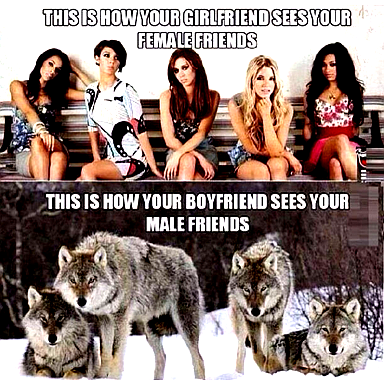

<ipython-input-5-cbfcdbb739d4>:104: DeprecationWarning: The parameter `use_angle_cls` has been deprecated and will be removed in the future. Please use `use_textline_orientation` instead.
  ocr = PaddleOCR(use_angle_cls=True, lang="en")  # uses GPU if available
Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Using official model (PP-LCNet_x1_0_doc_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/official_inference_model/paddle3.0.0/PP-LCNet_x1_0_doc_ori_infer.tar ...
[==================================================] 100.00%
Extracting PP-LCNet_x1_0_doc_ori_infer.tar
[==================================================] 100.00%


/usr/local/lib/python3.11/dist-packages/paddle/utils/cpp_extension/extension_utils.py:711: UserWarning: No ccache found. Please be aware that recompiling all source files may be required. You can download and install ccache from: https://github.com/ccache/ccache/blob/master/doc/INSTALL.md
  warnings.warn(warning_message)
Creating model: ('UVDoc', None)
Using official model (UVDoc), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/official_inference_model/paddle3.0.0/UVDoc_infer.tar ...
[==================================================] 100.00%
Extracting UVDoc_infer.tar
[==================================================] 100.00%


Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Using official model (PP-LCNet_x1_0_textline_ori), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/official_inference_model/paddle3.0.0/PP-LCNet_x1_0_textline_ori_infer.tar ...
[==================================================] 100.00%
Extracting PP-LCNet_x1_0_textline_ori_infer.tar
[==================================================] 100.00%


Creating model: ('PP-OCRv5_server_det', None)
Using official model (PP-OCRv5_server_det), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/official_inference_model/paddle3.0.0/PP-OCRv5_server_det_infer.tar ...
[==================================================] 100.00%
Extracting PP-OCRv5_server_det_infer.tar
[==================================================] 100.00%


Creating model: ('PP-OCRv5_server_rec', None)
Using official model (PP-OCRv5_server_rec), the model files will be automatically downloaded and saved in /root/.paddlex/official_models.


Connecting to https://paddle-model-ecology.bj.bcebos.com/paddlex/official_inference_model/paddle3.0.0/PP-OCRv5_server_rec_infer.tar ...
[==================================================] 100.00%
Extracting PP-OCRv5_server_rec_infer.tar
[==================================================] 100.00%


<ipython-input-5-cbfcdbb739d4>:107: DeprecationWarning: Please use `predict` instead.
  results = ocr.ocr(np.array(pil_original))


Raw PaddleOCR results:
 [{'input_path': None, 'page_index': None, 'doc_preprocessor_res': {'input_path': None, 'page_index': None, 'input_img': array([[[250, ..., 244],
        ...,
        [252, ..., 246]],

       ...,

       [[230, ..., 251],
        ...,
        [246, ..., 249]]], dtype=uint8), 'model_settings': {'use_doc_orientation_classify': True, 'use_doc_unwarping': True}, 'angle': 0, 'rot_img': array([[[250, ..., 244],
        ...,
        [252, ..., 246]],

       ...,

       [[230, ..., 251],
        ...,
        [246, ..., 249]]], dtype=uint8), 'output_img': array([[[240, ..., 236],
        ...,
        [235, ..., 212]],

       ...,

       [[115, ..., 104],
        ...,
        [186, ..., 189]]], dtype=uint8)}, 'dt_polys': [array([[57,  0],
       ...,
       [57, 30]], dtype=int16), array([[225,  34],
       ...,
       [225,  71]], dtype=int16), array([[ 51, 325],
       ...,
       [ 51, 358]], dtype=int16), array([[224, 366],
       ...,
       [224, 399]], dtype=i

In [ ]:
# 1) Install & import dependencies
!pip install paddlepaddle paddleocr torch torchvision pillow opencv-python --quiet

from PIL import Image, ImageEnhance
import cv2
import numpy as np
import torch
from torchvision import transforms
from IPython.display import display
from paddleocr import PaddleOCR

# 2) Define TrOCR‐style transforms (resize/pad, enhance, denoise, normalize)
class TrOCRTransforms:
    """
    1) Resize + pad to (384×384) with white background
    2) (Optional) Contrast + sharpness enhancement
    3) (Optional) Median‐blur noise removal
    4) ToTensor [0,1] → Normalize to [–1,+1]
    """
    def __init__(self,
                 target_size=(384, 384),
                 do_color_enhance=True,
                 contrast_factor=1.5,
                 sharpness_factor=2.0,
                 do_noise_removal=False,
                 noise_kernel_size=3):
        self.target_h, self.target_w = target_size
        self.do_color_enhance = do_color_enhance
        self.contrast_factor = contrast_factor
        self.sharpness_factor = sharpness_factor
        self.do_noise_removal = do_noise_removal
        self.noise_kernel_size = noise_kernel_size
        # Normalize maps [0,1] → [−1,+1]
        self.normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                              std =[0.5, 0.5, 0.5])

    def _resize_and_pad(self, pil_img: Image.Image) -> Image.Image:
        orig_w, orig_h = pil_img.size
        scale = min(self.target_w / orig_w, self.target_h / orig_h)
        new_w = int(orig_w * scale)
        new_h = int(orig_h * scale)
        img_resized = pil_img.resize((new_w, new_h), Image.BICUBIC)

        canvas = Image.new("RGB", (self.target_w, self.target_h), (255, 255, 255))
        paste_x = (self.target_w - new_w) // 2
        paste_y = (self.target_h - new_h) // 2
        canvas.paste(img_resized, (paste_x, paste_y))
        return canvas

    def _apply_color_enhancement(self, pil_img: Image.Image) -> Image.Image:
        enhancer = ImageEnhance.Contrast(pil_img)
        img_contrast = enhancer.enhance(self.contrast_factor)
        enhancer2 = ImageEnhance.Sharpness(img_contrast)
        img_sharp = enhancer2.enhance(self.sharpness_factor)
        return img_sharp

    def _apply_noise_removal(self, pil_img: Image.Image) -> Image.Image:
        cv_img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
        denoised = cv2.medianBlur(cv_img, self.noise_kernel_size)
        return Image.fromarray(cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB))

    def __call__(self, pil_img: Image.Image) -> torch.FloatTensor:
        # 1) Resize + pad
        img = self._resize_and_pad(pil_img)

        # 2) (Optional) Color enhancement
        if self.do_color_enhance:
            img = self._apply_color_enhancement(img)

        # 3) (Optional) Noise removal
        if self.do_noise_removal:
            img = self._apply_noise_removal(img)

        # 4a) ToTensor [0,1]
        tensor_img = transforms.ToTensor()(img)  # [3, 384, 384]

        # 4b) Normalize to [−1,+1]
        tensor_norm = self.normalize(tensor_img)
        return tensor_norm  # FloatTensor [3, 384, 384]

# 3) Load your meme as a PIL image
image_path = "/content/drive/MyDrive/MAMI2022/MAMI_2022_images/test_images/15006.jpg"
pil_original = Image.open(image_path).convert("RGB")

# 4) Apply TrOCRTransforms to visualize what TrOCR “sees”
trocr_preproc = TrOCRTransforms(
    target_size=(384, 384),
    do_color_enhance=True,
    contrast_factor=1.5,
    sharpness_factor=2.0,
    do_noise_removal=False
)
pixel_norm = trocr_preproc(pil_original)            # [3, 384, 384] in [−1,+1]

# 5) Un‐normalize back to [0,1] for visualization
pixel_01 = (pixel_norm * 0.5) + 0.5
pixel_01 = pixel_01.clamp(0.0, 1.0)

# 6) Convert [0,1] tensor back to PIL and display
pil_transformed = transforms.ToPILImage()(pixel_01.cpu())
display(pil_transformed)

# 7) Initialize PaddleOCR (detection + recognition)
ocr = PaddleOCR(use_angle_cls=True, lang="en")  # uses GPU if available

# 8) Run OCR on the original meme (not the transformed one)
results = ocr.ocr(np.array(pil_original))

# 9) Inspect raw results
print("Raw PaddleOCR results:\n", results, "\n")

# 10) results is now a list of length 1, containing a dict
ocr_dict = results[0]

# 11) Extract the detected polygons and recognized texts
#     – dt_polys: a list of Nx2 int16 arrays, each 4×2 corners
#     – rec_texts: a list of strings
polygons = ocr_dict["dt_polys"]       # list of arrays shape [4,2]
texts    = ocr_dict["rec_texts"]      # list of strings

# 12) Pair each text with its top‐edge y‐coordinate for sorting
lines = []
for poly, txt in zip(polygons, texts):
    # poly is a 4×2 array: [[x1,y1],[x2,y2],[x3,y3],[x4,y4]]
    # compute average of the two top corners (y1 + y2)/2
    # Usually poly[0] and poly[1] are top‐left, top‐right
    top_y = float((poly[0][1] + poly[1][1]) / 2.0)
    lines.append((top_y, txt))

# 13) Sort by top→bottom and concatenate
lines.sort(key=lambda x: x[0])
captions = [txt for _, txt in lines]
full_caption = " ".join(captions)

print("OCR detected text:\n", full_caption)


In [ ]:
# 1) Install & import dependencies
!pip install paddlepaddle paddleocr torch torchvision pillow opencv-python --quiet

from PIL import Image, ImageEnhance
import cv2
import numpy as np
import torch
from torchvision import transforms
from IPython.display import display
from paddleocr import PaddleOCR
import re

# 2) Define TrOCR‐style transforms (resize/pad, enhance, denoise, normalize)
class TrOCRTransforms:
    """
    1) Resize + pad to (384×384) with white background
    2) (Optional) Contrast + sharpness enhancement
    3) (Optional) Median‐blur noise removal
    4) ToTensor [0,1] → Normalize to [–1,+1]
    """
    def __init__(self,
                 target_size=(384, 384),
                 do_color_enhance=True,
                 contrast_factor=1.5,
                 sharpness_factor=2.0,
                 do_noise_removal=False,
                 noise_kernel_size=3):
        self.target_h, self.target_w = target_size
        self.do_color_enhance = do_color_enhance
        self.contrast_factor = contrast_factor
        self.sharpness_factor = sharpness_factor
        self.do_noise_removal = do_noise_removal
        self.noise_kernel_size = noise_kernel_size
        self.normalize = transforms.Normalize(mean=[0.5, 0.5, 0.5],
                                              std =[0.5, 0.5, 0.5])

    def _resize_and_pad(self, pil_img: Image.Image) -> Image.Image:
        orig_w, orig_h = pil_img.size
        scale = min(self.target_w / orig_w, self.target_h / orig_h)
        new_w = int(orig_w * scale)
        new_h = int(orig_h * scale)
        img_resized = pil_img.resize((new_w, new_h), Image.BICUBIC)

        canvas = Image.new("RGB", (self.target_w, self.target_h), (255, 255, 255))
        paste_x = (self.target_w - new_w) // 2
        paste_y = (self.target_h - new_h) // 2
        canvas.paste(img_resized, (paste_x, paste_y))
        return canvas

    def _apply_color_enhancement(self, pil_img: Image.Image) -> Image.Image:
        enhancer = ImageEnhance.Contrast(pil_img)
        img_contrast = enhancer.enhance(self.contrast_factor)
        enhancer2 = ImageEnhance.Sharpness(img_contrast)
        img_sharp = enhancer2.enhance(self.sharpness_factor)
        return img_sharp

    def _apply_noise_removal(self, pil_img: Image.Image) -> Image.Image:
        cv_img = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
        denoised = cv2.medianBlur(cv_img, self.noise_kernel_size)
        return Image.fromarray(cv2.cvtColor(denoised, cv2.COLOR_BGR2RGB))

    def __call__(self, pil_img: Image.Image) -> torch.FloatTensor:
        # 1) Resize + pad
        img = self._resize_and_pad(pil_img)

        # 2) (Optional) Color enhancement
        if self.do_color_enhance:
            img = self._apply_color_enhancement(img)

        # 3) (Optional) Noise removal
        if self.do_noise_removal:
            img = self._apply_noise_removal(img)

        # 4a) ToTensor [0,1]
        tensor_img = transforms.ToTensor()(img)  # [3, 384, 384]

        # 4b) Normalize to [–1,+1]
        tensor_norm = self.normalize(tensor_img)
        return tensor_norm  # FloatTensor [3, 384, 384]

# 3) Load your meme as a PIL image
image_path = "/content/drive/MyDrive/MAMI2022/MAMI_2022_images/test_images/15008.jpg"
pil_original = Image.open(image_path).convert("RGB")

# 4) Apply TrOCRTransforms to visualize what TrOCR “sees”
trocr_preproc = TrOCRTransforms(
    target_size=(384, 384),
    do_color_enhance=True,
    contrast_factor=1.5,
    sharpness_factor=2.0,
    do_noise_removal=False
)
pixel_norm = trocr_preproc(pil_original)            # [3, 384, 384] in [–1,+1]

# 5) Un‐normalize back to [0,1] for visualization
pixel_01 = (pixel_norm * 0.5) + 0.5
pixel_01 = pixel_01.clamp(0.0, 1.0)

# 6) Convert [0,1] tensor back to PIL and display
pil_transformed = transforms.ToPILImage()(pixel_01.cpu())
display(pil_transformed)

# 7) Initialize PaddleOCR (detection + recognition)
ocr = PaddleOCR(use_angle_cls=True, lang="en")

# 8) Run OCR on the original meme
results = ocr.ocr(np.array(pil_original))

# 9) Extract dt_polys and rec_texts from the returned dictionary
ocr_dict = results[0]
polygons = ocr_dict["dt_polys"]    # list of 4×2 int16 arrays
texts    = ocr_dict["rec_texts"]   # list of raw strings

# 10) Pair each text with its top-edge y-coordinate for sorting
pairs = []
for poly, txt in zip(polygons, texts):
    top_y = float((poly[0][1] + poly[1][1]) / 2.0)
    pairs.append((top_y, txt))

# 11) Sort by vertical position (top→bottom)
pairs.sort(key=lambda x: x[0])
raw_caption = " ".join([txt for _, txt in pairs])
print("Raw OCR output:\n", raw_caption, "\n")

# 12) Semantic post‐processing: remove garbage tokens, fix spacing & punctuation
def semantic_clean(text: str) -> str:
    # a) Lowercase for filtering, but keep original for output
    tokens = text.split()
    clean_tokens = []
    for t in tokens:
        # Remove tokens that are purely non-alpha (e.g., URLs, weird punctuation)
        if re.match(r"^[A-Za-z']+$", t):
            clean_tokens.append(t)
        # Also keep tokens with apostrophes like "I'm", "don't"
        elif re.match(r"^[A-Za-z]+'[A-Za-z]+$", t):
            clean_tokens.append(t)
        # Otherwise drop “garbage” token

    # b) Join tokens, ensure single spaces
    joined = " ".join(clean_tokens)

    # c) Fix spacing before punctuation (none in this example, but for completeness)
    joined = re.sub(r"\s+([.,!?;:])", r"\1", joined)

    # d) Ensure space after punctuation
    joined = re.sub(r"([.,!?;:])([A-Za-z])", r"\1 \2", joined)

    # e) Capitalize the first letter of each sentence
    sentences = re.split(r"([.!?])\s*", joined)
    out_sentences = []
    for i in range(0, len(sentences) - 1, 2):
        sent = sentences[i].strip()
        punct = sentences[i+1]
        if sent:
            out_sentences.append(sent.capitalize() + punct)
    if len(sentences) % 2 == 1:
        last = sentences[-1].strip()
        if last:
            out_sentences.append(last.capitalize())

    return " ".join(out_sentences)

cleaned_caption = semantic_clean(raw_caption)
print("Cleaned OCR result:\n", cleaned_caption)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.4/72.4 kB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.8/192.8 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.5/65.5 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 49.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 43.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 40.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.5/51.5 kB 2.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 472.3/472.3 kB 30.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.7/68.7 MB 10.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject